# filter temporally surface fields

To do:

- split the notebooks into several ones:
    - isolated locations: spectra, overview of band-pass filtering, sensitivity to filter bandwidth
    - domain movies, one notebook per domain
- join face 7 and 10 for CalVal work?



In [1]:
import os

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.sigp as sp

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=5) # enough for a couple of locations
    # for full face filtering:
    cluster = PBSCluster(cores=12, processes=6)
    w = cluster.scale(jobs=30)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.135.39.36:41514 Dashboard: /user/pontea/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## define the filter and utils

In [4]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .2, "semidiurnal"

h = sp.generate_filter(omega, T=10, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


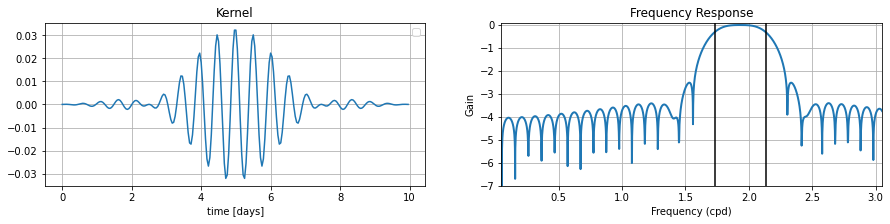

In [5]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color='k')
ax.axvline(omega+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [6]:
from scipy import signal

def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1)
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [7]:
grd = ut.load_grd()[['XC', 'YC', 'Depth']]

def load_zarr(v, face, dij=None, grid=True, rechunked=False):
    zarr = os.path.join(ut.work_data_dir,
                    'rechunked/{}_f{:02d}_{}.zarr'.format(v, face, name)
                   )
    if rechunked:
        zarr = zarr.replace(".zarr", "_rechunked.zarr")
    ds = xr.open_zarr(zarr)
    #
    if dij is not None:
        ds = ds.isel(i=slice(0,None, dij), j=slice(0,None, dij))
    if grid:
        ds = ds.merge(grd.sel(face=face), join="inner")
    return ds

---
## selected locations


In [8]:
ds = ut.load_data(["Eta", "SSU", "SSV"])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

see [this notebook](https://nbviewer.jupyter.org/github/apatlpo/mit_equinox/blob/master/sandbox/plot_uv.ipynb) to pick points

In [9]:
points = dict(south_atlantic=[1, 1000, 2000],
              north_pacific=[7, 3000, 3000],
             )

/home/mp/pontea/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/mp/pontea/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/mp/pontea/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonic

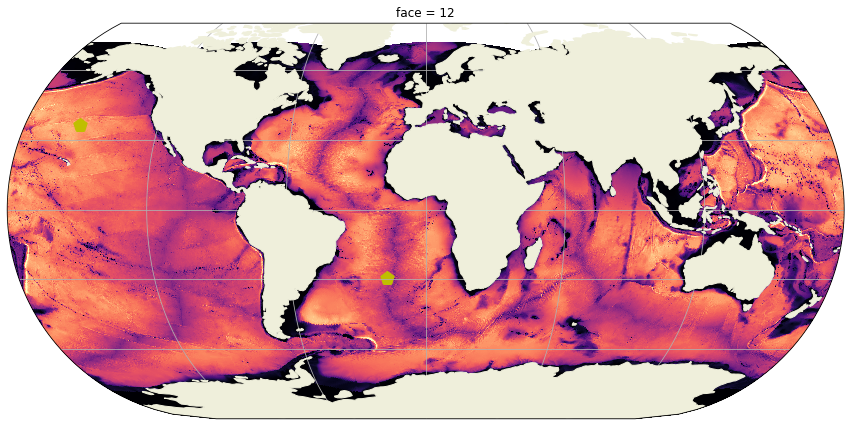

In [10]:
h = pl.plot_pretty(grd.Depth.isel(i=slice(0,None,4), 
                                  j=slice(0,None,4),
                                 ), 
                   infer_intervals=True,
                  )

ax = h["ax"]
for p, i in points.items():
    _g = grd.isel(face=i[0], i=int(i[1]), j=int(i[2]))
    _g.plot.scatter(ax=ax, 
                    x="XC",y="YC", 
                    s=200, marker="p", c="y",
                    transform=ccrs.PlateCarree(),)

In [51]:
_d = xr.DataArray(list(points),dims="point", name="point")
# the line below might be very inefficient
dsp = xr.concat([ds.isel(face=i[0], i=i[1], i_g=i[1], j=int(i[2])) 
                 for p, i in points.items()], 
                dim=_d,
               )
dsp = dsp.chunk({"time": -1}).persist()
dsp

<xarray.Dataset>
Dimensions:  (point: 2, time: 8785)
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
    dtime    (time) datetime64[ns] dask.array<chunksize=(8785,), meta=np.ndarray>
    face     (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    i        (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    iters    (time) int64 dask.array<chunksize=(8785,), meta=np.ndarray>
    j        (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    i_g      (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * point    (point) <U14 'south_atlantic' 'north_pacific'
Data variables:
    Eta      (point, time) float32 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SSU      (point, time) float32 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SST      (point, time) float32 dask.array<chunksize=(1, 8785), meta=np.ndarray>

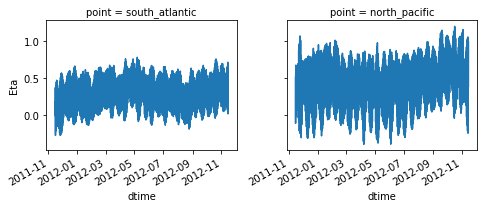

In [52]:
dsp["Eta"].plot.line(x="dtime", col='point')

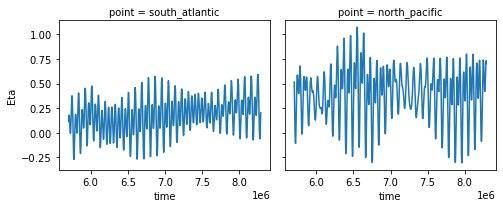

In [53]:
dsp["Eta"].isel(time=slice(24*30)).plot.line(x="time", col='point')

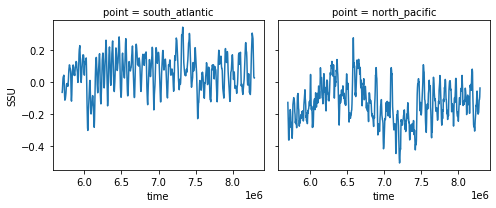

In [54]:
dsp["SSU"].isel(time=slice(24*30)).plot.line(x="time", col='point')

In [56]:
for v in dsp:
    dsp[v+"_hat"] = filt(dsp[v], h)

In [57]:
dsp

<xarray.Dataset>
Dimensions:      (point: 2, time: 8785)
Coordinates:
  * time         (time) float64 5.702e+06 5.706e+06 ... 3.732e+07 3.732e+07
    dtime        (time) datetime64[ns] dask.array<chunksize=(8785,), meta=np.ndarray>
    face         (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    i            (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    iters        (time) int64 dask.array<chunksize=(8785,), meta=np.ndarray>
    j            (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    i_g          (point) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * point        (point) <U14 'south_atlantic' 'north_pacific'
Data variables:
    Eta          (point, time) float32 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SSU          (point, time) float32 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SST          (point, time) float32 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    Eta_hat      (point, time) float64 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SSU_hat      (point, time) float64 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SST_hat      (point, time) float64 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    Eta_hat_hat  (point, time) float64 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SSU_hat_hat  (point, time) float64 dask.array<chunksize=(1, 8785), meta=np.ndarray>
    SST_hat_hat  (point, time) float64 dask.array<chunksize=(1, 8785), meta=np.ndarray>

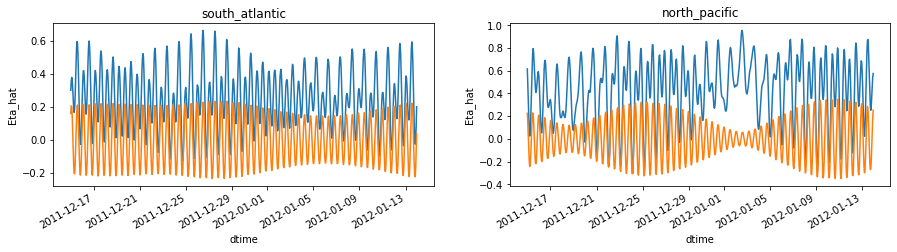

In [63]:
fig, axes =  plt.subplots(1,2, figsize=(15,3))

_ds = dsp.isel(time=slice(30*24,60*24))
v = "Eta"

for p, ax in zip(dsp.point, axes):
    _ds[v].sel(point=p).plot.line(ax=ax, x="dtime")
    _ds[v+"_hat"].sel(point=p).plot.line(ax=ax, x="dtime")
    ax.set_title(p.values)

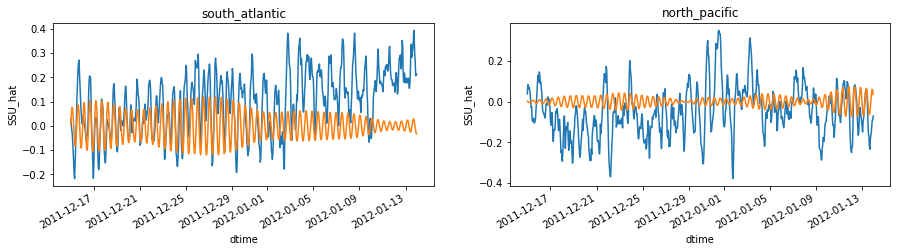

In [64]:
fig, axes =  plt.subplots(1,2, figsize=(15,3))

_ds = dsp.isel(time=slice(30*24,60*24))
v = "SSU"

for p, ax in zip(dsp.point, axes):
    _ds[v].sel(point=p).plot.line(ax=ax, x="dtime")
    _ds[v+"_hat"].sel(point=p).plot.line(ax=ax, x="dtime")
    ax.set_title(p.values)

---
## filter a full face

dask cluster: 

- `cluster = PBSCluster(cores=12, processes=6)`
- 30 jobs (3TB RAM)

The cluster above is a bare minimum

The final chunk size needs to be small enough for data to fit within each worker= `(144, 77, -1)`

In [8]:
face = 7 # done: 1

# load data
dsU = xr.open_zarr(ut.work_data_dir+'rechunked/%s_f%02d.zarr'%('SSU',face))
dsV = xr.open_zarr(ut.work_data_dir+'rechunked/%s_f%02d.zarr'%('SSV',face))
dsE = xr.open_zarr(ut.work_data_dir+'rechunked/%s_f%02d.zarr'%('Eta',face)) # not on same time line at the moment

grd = ut.load_grd()[['XC', 'YC', 'Depth']]

ds = xr.merge([dsU.rename({'i_g': 'i'}), dsV.rename({'j_g': 'j'}), dsE], 
              compat='equals').assign_coords(**grd.sel(face=face))
#
#dsE = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%(v,face))
#ds = dsE.assign_coords(**grd_rspec.sel(face=face))

# spatial subsetting
#ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))

# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

# rechunk along time
ds = ds.chunk(dict(time=-1, i=144, j=72))

# for plotting purposes
#ds = ds.swap_dims({'time':'dtime'}).drop('time').rename({'dtime':'time'})

for v in ds:
    if "_hat" not in v:
        ds[v+"_hat"] = filt(ds[v], h, hilbert=True)

ds

dataset size: 1967.2 GB


<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8784)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<chunksize=(8784,), meta=np.ndarray>
    face     int64 7
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<chunksize=(8784,), meta=np.ndarray>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8784, 72, 144), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8784, 72, 144), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(8784, 72, 144), meta=np.ndarray>

In [10]:
# store, may need to use custom_distribute
#v = "Eta"
for v in ds:
    if "_hat" not in v:
        _ds = (ds[v+"_hat"]
               .astype(np.complex64)  # change type for storage
               .to_dataset()
              )
        zarr = os.path.join(ut.work_data_dir,
                    'rechunked/{}_f{:02d}_{}.zarr'.format(v, face, name)
                   )
        _ds = _ds.chunk(dict(time=int(_ds.time.size/2)))
        del _ds.iters.encoding['chunks']
        _ds.to_zarr(zarr, mode="w")

In [ ]:
cluster.close()

### subsample and rechunk

In [12]:
from rechunker import rechunk
from shutil import rmtree

In [14]:
face = 7 # done: 1

scale = 4

#for v in ["Eta", "SSU", "SSV"]:
for v in ["SSU", "SSV"]:
    
    ds = load_zarr(v, face, grid=False)
    
    target_chunks = {v+"_hat": dict(time=int(ds.time.size/scale**2),
                             i=72*scale,
                             j=72*scale,
                            )
                    }
    zarr = os.path.join(ut.work_data_dir,
                'rechunked/{}_f{:02d}_{}_rechunked.zarr'.format(v, face, name)
               )
    temp_store = os.path.join(ut.scratch, "tmp.zarr")

    rmtree(zarr, ignore_errors=True)
    rmtree(temp_store, ignore_errors=True)

    del ds[v+"_hat"].encoding['chunks'], ds["iters"].encoding['chunks']
    r = rechunk(ds, target_chunks, "5GB", zarr, 
                temp_store=temp_store,
               )

    %time r.execute()

CPU times: user 28.7 s, sys: 1.88 s, total: 30.5 s
Wall time: 1min 29s
CPU times: user 28.7 s, sys: 1.92 s, total: 30.6 s
Wall time: 1min 33s


In [15]:
sp.print_rechunk(r, "SSV_hat")

Source data size: 		 4320x4320x8784 	 1311.4GB
Source chunk size: 		 72x144x4392		 182.1MB
Source number of files: 		 3600
Intermediate chunk size: 	 72x144x4392		 182.1MB
Intermediate number of files: 		 3600
Target chunk size: 		 288x288x549 		 182.1MB
Target number of files: 		 3600


In [59]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 120.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


### inspect result

In [16]:
cluster.scale(jobs=5)

In [52]:
face = 1
dij = 2
ds_hat = xr.merge([load_zarr(v, face, dij=dij, rechunked=True) 
                   for v in ["Eta", "SSU", "SSV"]],
                 )

In [10]:
_ds = (ds_hat
       .isel(time=30*24)
       .chunk(dict(i=-1, j=-1))
       .persist()
      )

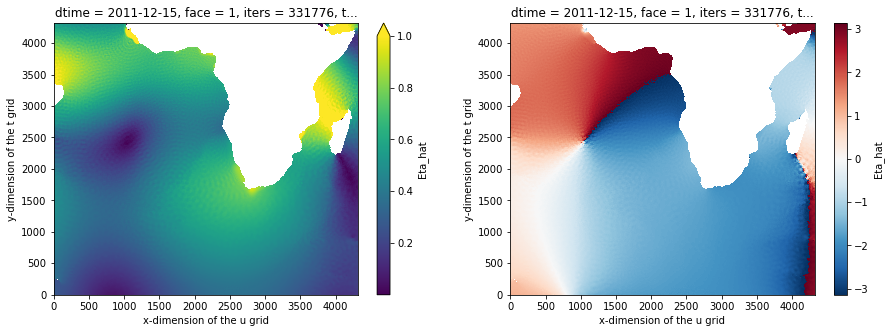

In [22]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
np.abs(_ds["Eta_hat"]).plot(ax=axes[0], vmax=1.)
xr.ufuncs.angle(_ds["Eta_hat"]).plot(ax=axes[1])

In [44]:
def plot_ri(ds, v, i=None, j=None, **kwargs):
    _ds = ds
    if i is not None:
        _ds = _ds.sel(i=i)
    if j is not None:
        _ds = _ds.sel(j=j)
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    kw = dict(x="XC", y="YC", **kwargs)
    np.real(_ds[v+"_hat"]).plot(ax=axes[0], **kw)
    axes[0].set_title("real({}_M2) {}".format(v,_ds.dtime.dt.strftime("%Y-%M%d").values))
    np.imag(_ds[v+"_hat"]).plot(ax=axes[1], **kw)
    axes[1].set_title("imag({}_M2) {}".format(v,_ds.dtime.dt.strftime("%Y-%M%d").values))

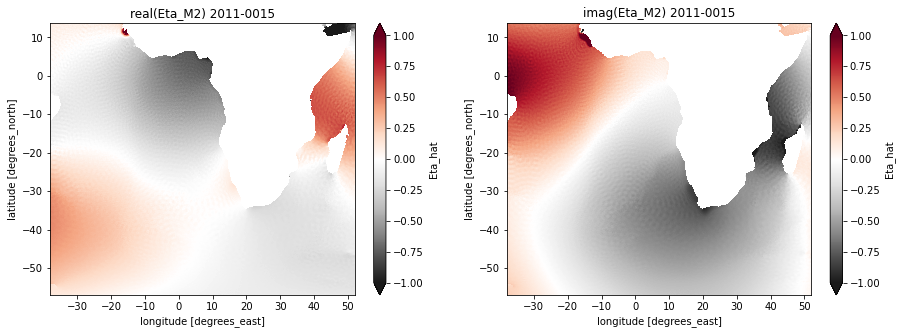

In [35]:
plot_ri(_ds, "Eta", vmax=1., cmap="RdGy_r")

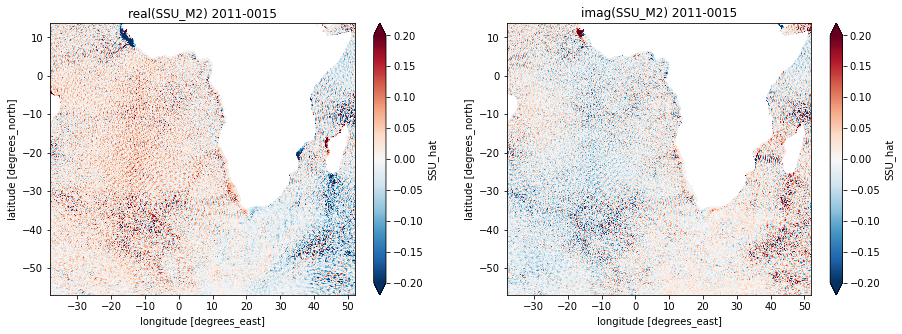

In [37]:
plot_ri(_ds, "SSU", vmax=.2)

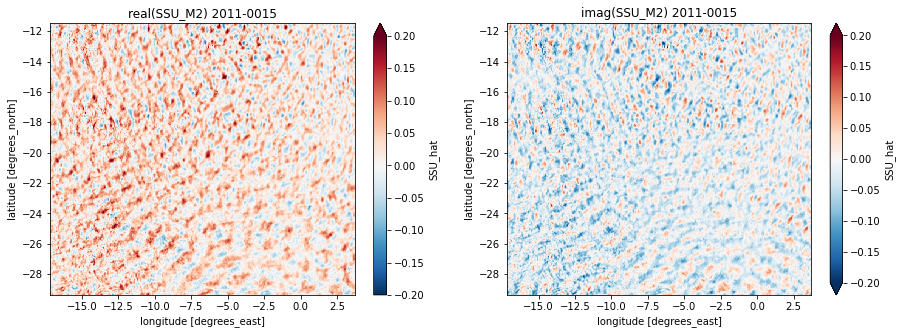

In [45]:
plot_ri(_ds, "SSU", vmax=.2, i=slice(1000,2000), j=slice(2000,3000))

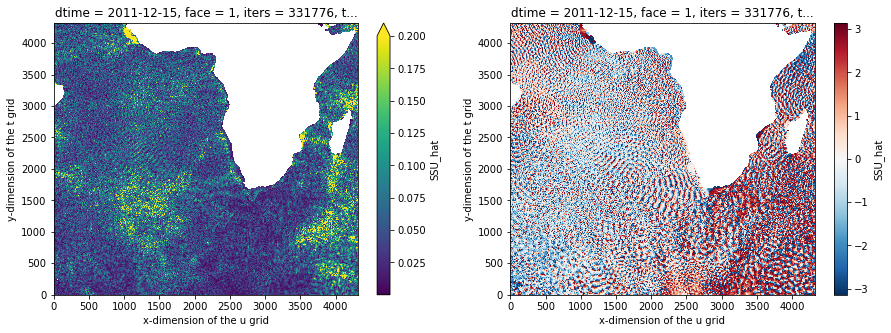

In [23]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
np.abs(_ds["SSU_hat"]).plot(ax=axes[0], vmax=.2)
xr.ufuncs.angle(_ds["SSU_hat"]).plot(ax=axes[1])

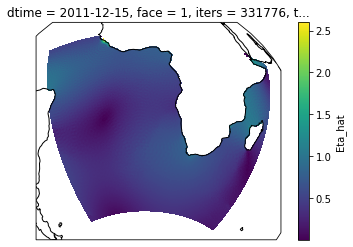

In [25]:
import cartopy.crs as ccrs

p = np.abs(_ds["Eta_hat"]).plot(x="XC", y="YC", 
                                subplot_kws=dict(projection=ccrs.Orthographic(0, -35), 
                                                ), #facecolor="gray"
                        transform=ccrs.PlateCarree(),
                       )

#p.axes.set_global()

p.axes.coastlines()
#p.axes.land()

### isolated locations

In [53]:
face = 1
dij = 2
ds_hat = xr.merge([load_zarr(v, face, dij=dij, rechunked=True) 
                   for v in ["Eta", "SSU", "SSV"]],
                 )
#ds_hat

In [56]:
ij = []
ij.append((2500, 1500))
ij.append((500, 3500))

t_start, delta_t = 30*24, 60*24

ds = xr.concat([ds_hat.sel(i=_ij[0], j=_ij[1]) for _ij in ij], dim="points").persist()
ds["exp"] = np.exp(-1j*2.*np.pi*tidal_omega["M2"]*ds.time/86400)

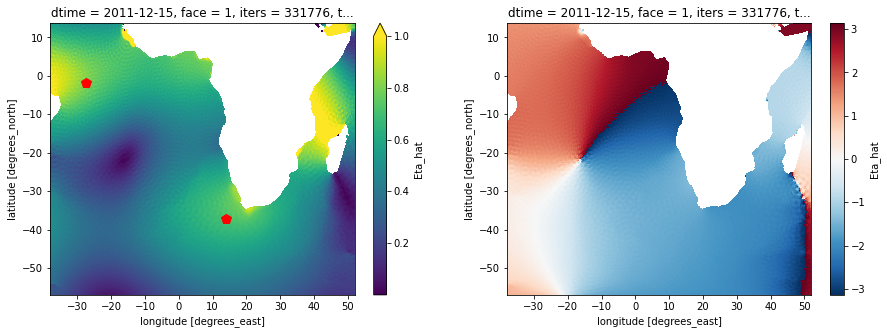

In [55]:
_ds = ds_hat.isel(time=t_start)
fig, axes = plt.subplots(1,2, figsize=(15,5))
np.abs(_ds["Eta_hat"]).plot(x="XC", y="YC", ax=axes[0], vmax=1.)
xr.ufuncs.angle(_ds["Eta_hat"]).plot(x="XC", y="YC", ax=axes[1])

for _lon, _lat in zip(ds.XC, ds.YC):
    axes[0].plot(_lon, _lat, marker="p", c="r", ms=10)
#ds["Eta_hat"].plot.line(x="XC", y="YC", ax=axes[0], marker="p", c="y",)

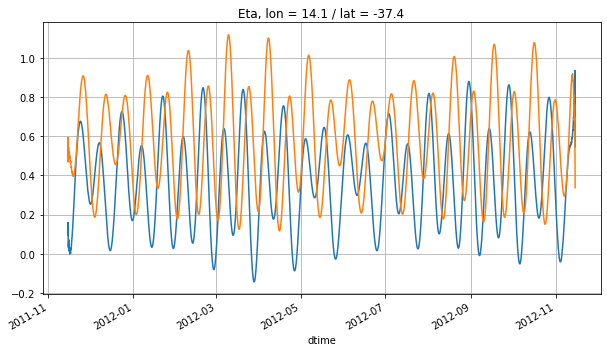

In [68]:
#_ds = ds.isel(time=slice(30*24,90*24))
def plot_ri_tseries(ds, v, point, t=None):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    _d = (ds[v+"_hat"]*ds.exp).isel(points=point)
    if t is not None:
        _d = _d.isel(time=t)
    np.real(_d).plot.line(ax=ax, x="dtime")
    np.imag(_d).plot.line(ax=ax, x="dtime")
    ax.grid()
    ax.set_title("{}, lon = {:.1f} / lat = {:.1f}".format(v, 
                                                          _d.XC.values,
                                                          _d.YC.values,
                                                         )
                )

plot_ri_tseries(ds, "Eta", 0)

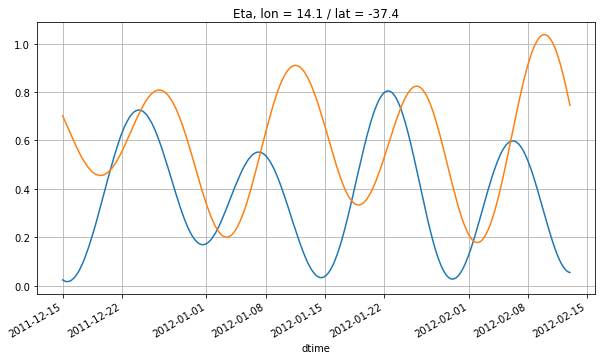

In [69]:
plot_ri_tseries(ds, "Eta", 0, t=slice(t_start, t_start+delta_t))

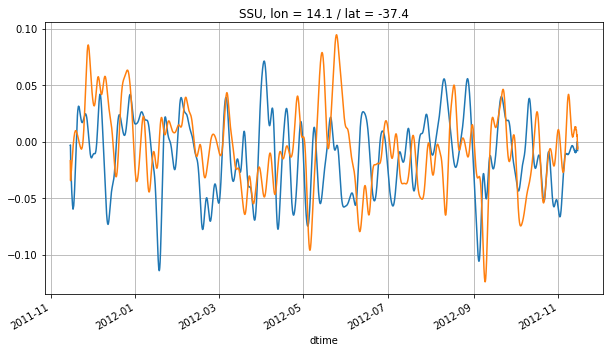

In [66]:
plot_ri_tseries(ds, "SSU", 0)

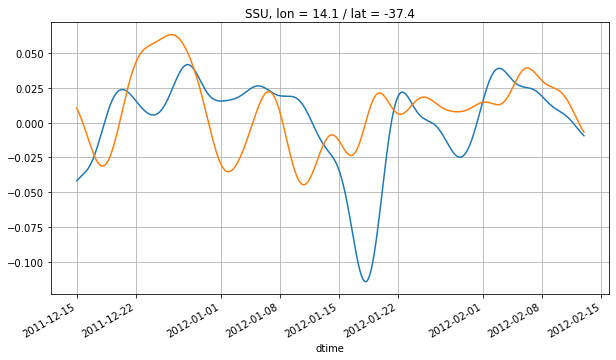

In [70]:
plot_ri_tseries(ds, "SSU", 0, t=slice(t_start, t_start+delta_t))

In [71]:
cluster.close()

### make movies

In [9]:
from dask import delayed
import pandas as pd

In [30]:
face = 1
dij = 2
t_start, t_end, dt = 30*24, 120*24, 6

10,-25
region = dict(name="south-atlantic",
              faces=[1],
              extent=[-30, 30, -40, -5],
              dticks=[5, 5],
              projection=ccrs.LambertAzimuthalEqualArea(central_longitude=10.0, central_latitude=-25),
             )
figsize = (13, 8)

In [11]:
ds_hat = xr.merge([load_zarr(v, face, dij=dij, rechunked=True) 
                   for v in ["Eta", "SSU", "SSV"]],
                 )
ds_hat = ds_hat.isel(time=slice(t_start, t_end, dt))
ds_hat["exp"] = np.exp(-1j*2.*np.pi*tidal_omega["M2"]*ds_hat.time/86400)
#ds_hat

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160, time: 360)
Coordinates:
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
    dtime    (time) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    face     int64 1
    iters    (time) int64 dask.array<chunksize=(360,), meta=np.ndarray>
  * time     (time) float64 8.294e+06 8.316e+06 ... 1.603e+07 1.605e+07
    XC       (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
Data variables:
    Eta_hat  (j, i, time) complex64 dask.array<chunksize=(144, 144, 63), meta=np.ndarray>
    SSU_hat  (j, i, time) complex64 dask.array<chunksize=(144, 144, 63), meta=np.ndarray>
    SSV_hat  (j, i, time) complex64 dask.array<chunksize=(144, 144, 63), meta=np.ndarray>
    exp      (time) complex128 (-0.9999407159610388-0.010888735616449647j) .....

In [36]:
v = "Eta"
vmin, vmax = -1, 1

#v="SSU"
#vmin, vmax = -.3, .3

ds = (np.real(ds_hat[v+"_hat"]*ds_hat["exp"])
      .expand_dims("face")
      .rename(v)
      .to_dataset()
      .persist()
     )
print("min = {:.1f}, max = {:.1f} ".format(ds[v].min().values, 
                                           ds[v].max().values)
     )

min = -3.0, max = 2.0 


In [37]:
# could delete all figures beforehand
figdir = ut.scratch+'figs/'
print('Figures directory: '+figdir)

def genfig(ds, v, i, pretty=True, overwrite=True):
    
    #region = 'south-atlantic'
    
    # !! passing the variable does not work
    dv = ds[v]

    #time = pd.to_datetime(str(eta['time'].values))
    #time = dv['time'].values/86400.
    time = pd.to_datetime(dv['dtime'].values)
    #figname = figdir+'%s_f%d_t%05d' %(v, face, i)+'.png'
    figname = figdir+'%s_%s_t%05d' %(v, region["name"], i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        if pretty:
            _ = pl.plot_pretty(dv, vmin=vmin, vmax=vmax, region=region,
                                  colorbar=True, #colorbar_kwargs=dict(shrink=.5),
                               title=title, savefig=figname,
                                gridlines=False, figsize=figsize,
                                  offline=True)
        else:
            _ = pl.plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=False, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


In [38]:
I = range(len(ds['time']))
#I = range(10)
values = [delayed(genfig)(ds.isel(time=i), v, i) for i in I]

In [39]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 58.7 s, sys: 2.26 s, total: 1min
Wall time: 1min 27s


In [49]:
cg = 2 # m/s Alford and Zhongxiao 2007
print("Distance of propagation (mode 1) after 14d = {:.0f} km".format(cg*14*86400/1e3))

Distance of propagation after 14d = 2419 km


### plot domain averaged diagnostics (Eta, SSU/SSV, normalized)

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [18]:
cluster.close()